# Seminar 5: Basic Artificial Neural Networks

The goal of this seminar is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of the following scaffolding was heavily inspired by [Caffe](http://caffe.berkeleyvision.org/) which is a good thing as this package will be used extensively later in the course. 

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython import display

## Perceptrons for digit classification 

Again, we are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. First 60,000 samples are intended for training and validation (for simplicity, we'll use the whole chunk for training), and the rest 10,000 is a test set.

In [2]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("MNIST original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

### Defining layers

Each of the modern Deep Learning packages defines a set of **layers** which are used as building blocks for the complete Neural Network. In a nut shell, layer is some kind of transformation applied to the input data. It should be differentiable for the back-propagation to work. As it is usually done, the data is stored in so-called **blobs**. In our case blobs are just pairs of regular 2D matrices of size $ (N \times C) $, where $ N $ is the number of samples in a batch, $ C $ is the number of channels in a sample. Here is a small example of a blob:

In [3]:
N = 100
C = 512

blob = {
    'data': np.zeros((N, C)),
    'diff': np.zeros((N, C)),
}

The code above defines a blob for a batch of 100 samples with 512 channels per sample. The actual data is held in `blob['data']`, while `blob['diff']` is used as a storage for data gradients, i.e. $ \frac{\partial \, \mathtt{Objective}}{\partial \, \mathtt{Data}} $.  

The following code defines a common interface for every layer that we are going to use in our network. The **`bottom`** corresponds to the list of input blobs of the layer (some layers may receive multiple input blobs) and the **``top``** is a list (most commonly containing only one element) of output blobs.

In [3]:
from abc import ABCMeta, abstractmethod

class BaseLayer:
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def reshape(self, bottom, top):
        """
        Reshapes (resizes) top blobs accoring to the size of bottom blobs and internal
        parameters of the layer. The idea here is to allocate all the blobs only once
        avoiding repeated creation of arrays during the optimization process.

        Keyword arguments:
        bottom -- list of input blobs
        top    -- list of output blobs
        """
        pass

    @abstractmethod
    def fprop(self, bottom, top):
        """
        Applies layer transformation to the list of input blobs and writes the results
        to the list of the output blobs.

        Keyword arguments:
        bottom -- list of input blobs
        top    -- list of output blobs
        """
        pass

    @abstractmethod
    def bprop(self, top, bottom):
        """
        Computes (d Objective) / (d Data) for all input blobs and stores the result for
        the i-th blob to bottom[i]['diff'].

        Keyword arguments:
        bottom -- list of input blobs
        top    -- list of output blobs
        """
        pass

Now that we have defined the interface, it's time implement a bunch of actual layers. It's up to you to define more modules. Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**): 

In [4]:
class ReLULayer(BaseLayer):
    def __init__(self):
        pass
    
    def reshape(self, bottom, top):
        top[0]['data'] = bottom[0]['data']
        top[0]['diff'] = bottom[0]['diff']
        self.mask = np.zeros(bottom[0]['data'].shape)
    
    def fprop(self, bottom, top):
        np.maximum(bottom[0]['data'], 0.0, out=top[0]['data'])

    def bprop(self, top, bottom):
        self.mask[:] = bottom[0]['data'] > 0.0
        np.multiply(top[0]['diff'], self.mask, out=bottom[0]['diff'])

In [5]:
# The following 3 functors are needed for the weight initialization.

class ConstantFiller:
    '''Returns a matrix filled with the specified value.'''
    def __init__(self, value):
        self.value = value
        
    def __call__(self, shape):
        return self.value * np.ones(shape)

class GaussianFiller:
    '''Returns a matrix filled with a gaussian noise ~ N(mu, sigma).'''
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def __call__(self, shape):
        return np.random.normal(self.mu, self.sigma, size=shape)
    
class XavierFiller:
    '''
    Returns a matrix filled uniform noise tailored to speed-up ANN learning.
    
    References:
    * Glorot et al., 2010: 
    http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
    '''
    def __init__(self):
        pass
        
    def __call__(self, shape):
        fan_in = shape[0]
        fan_out = shape[1]
        delta = np.sqrt(6.0 / (fan_in + fan_out))
        return np.random.uniform(-delta, delta, size=shape)

It's your turn to implement the **Fully-connected** layer (``InnerProductLayer`` in the code) and the **Softmax + Multinomial Logistic Loss** combo (``SoftmaxLossLayer`` in the code):

In [6]:
class InnerProductLayer(BaseLayer):
    """
    Fully-connected layer. Computes input * W + b.
    """
    def __init__(self, channels, filters, **keywords):
        self.filters = filters
        self.channels = channels
        
        self.params = {
            'W': {
                'data': np.zeros((channels, filters)),
                'diff': np.zeros((channels, filters))
            },
            'b': {
                'data': np.zeros((1, filters)),
                'diff': np.zeros((1, filters))
            }
        }
        
        for k in self.params.keys():
            self.params[k]['data'][:] = keywords[k](self.params[k]['data'].shape)
            
    def reshape(self, bottom, top):
        top[0]['data'] = np.zeros((bottom[0]['data'].shape[0], self.filters))
        top[0]['diff'] = np.zeros((bottom[0]['data'].shape[0], self.filters))
    
    def fprop(self, bottom, top):
        np.dot(bottom[0]['data'], self.params['W']['data'], out=top[0]['data'])
        top[0]['data'] = top[0]['data'] + self.params['b']['data']

    def bprop(self, top, bottom):
        np.dot(bottom[0]['data'].transpose(), top[0]['diff'], out=self.params['W']['diff'])
        self.params['b']['diff'] = np.sum(top[0]['diff'], axis=0)
        np.dot(top[0]['diff'], self.params['W']['data'].transpose(), out=bottom[0]['diff'])

In [7]:
class SoftmaxLossLayer(BaseLayer):
    """
    Computes the multinomial logistic loss of the softmax of its inputs. It’s 
    conceptually identical to a softmax layer followed by a multinomial logistic 
    loss layer, but provides a more numerically stable gradient.
    
    References:
    * Softmax:
    http://en.wikipedia.org/wiki/Softmax_function
    * Multinomial logistic loss:
    http://en.wikipedia.org/wiki/Multinomial_logistic_regression
    http://caffe.berkeleyvision.org/doxygen/classcaffe_1_1SoftmaxWithLossLayer.html
    http://caffe.berkeleyvision.org/doxygen/classcaffe_1_1MultinomialLogisticLossLayer.html#details
    """
    def __init__(self):
        pass
    
    def reshape(self, bottom, top):
        top[0]['data'] = np.zeros((1,))
        top[0]['diff'] = np.zeros((1,))
        self.probs = np.zeros(bottom[0]['data'].shape)
    
    def fprop(self, bottom, top):
        self.probs = np.exp(bottom[0]['data']) /  np.vstack(np.sum(np.exp(bottom[0]['data']), axis=1))
        for i in xrange(bottom[0]['data'].shape[0]):
            top[0]['data'][0] -= np.log(self.probs[i, bottom[1]['data'][i]]) 
        top[0]['data'][0] /= bottom[0]['data'].shape[0]

    def bprop(self, top, bottom):
        bottom[0]['diff'] = self.probs / bottom[0]['data'].shape[0]
        for i in xrange(bottom[0]['data'].shape[0]):
            bottom[0]['diff'][i, bottom[1]['data'][i]] -= 1. /  bottom[0]['data'].shape[0]

### Defining a complete model

We are going to assemble freshly coded layers into a complete model by means of additional class ``MLP`` (i.e. **Multi-layer perceptron**). Before we start, let's briefly look at how one would use it:

Ok, let's proceed to the implementation:

In [8]:
class MLP:
    """
    Multi-layer perceptron class.
    """
    def __init__(self, desc):
        self.layers = desc
        self.reshaped = False
        
        # Here we aggregate all tunable parameters into a single list.
        self.params = []
        for l in self.layers:
            try:
                for v in l.params.values():
                    self.params.append(v)
            except Exception, e:
                pass
    
    def reshape(self, input_shape):
        """
        Invokes reshape methods of all layers.
        """
        batch_size = input_shape[0]
        self.data = {
            'data': np.zeros(input_shape), 
            'diff': np.zeros(input_shape)
        }
        self.labels = {
            'data': np.zeros((batch_size, 1), dtype=np.int32)
        }
        
        self.blobs = [] # Holds all internal blobs created by reshape methods.
        
        # Your code goes here. ################################################ 
        self.blobs.append(self.data)
        for layer in desc:
            new_bottom = [{'data': None, 'diff': None}]
            layer.reshape(self.blobs[-1:], new_bottom)
            self.blobs.append(new_bottom[0])
        # Your code goes here. ################################################ 
        
        self.reshaped = True
    
    def set_input(self, data, labels):
        if not self.reshaped:
            self.reshape(data.shape)
            
        # Populate self.data and self.labels.
        # Your code goes here. ################################################
        self.data = {'data':data, 'diff':np.zeros(data.shape)}
        self.labels = {'data':labels}
        # Your code goes here. ################################################
        
    def fprop(self):
        """
        Conducts forward-propagation through the network.
        
        (i.e. fills self.blobs[:]['data'])
        """
        # Your code goes here. ################################################ 
        for i in xrange(len(self.layers) - 1):
            self.layers[i].fprop(self.blobs[i:i+1], self.blobs[i+1:i+2])
        self.layers[-1].fprop([self.blobs[len(self.layers) - 1], self.labels], \
                               self.blobs[len(self.layers):])
        # Your code goes here. ################################################ 
        # NOTE: Keep in mind that the last layer should receive ground-truth 
        #       labels as well as blob from the lower layer.
        
    def bprop(self):
        """
        Conducts backward-propagation through the network.
        
        (i.e. fills self.blobs[:]['diff'] and updates 'diff's of the internal 
        weight blobs)
        """
        # Your code goes here. ################################################ 
        self.layers[-1].bprop(self.blobs[len(self.layers):], [self.blobs[len(self.layers)-1], self.labels])
        for i in xrange(1, len(self.layers)):
            self.layers[len(self.layers) - 1 - i].bprop(\
                                    self.blobs[len(self.blobs) - 1 - i:len(self.blobs) - i], \
                                    self.blobs[len(self.blobs) - 2 - i:len(self.blobs) - 1 - i])
        for i in xrange(len(self.params)):
            self.params[i]['data'] -= self.params[i]['diff']
        # Your code goes here. ################################################ 
        
    def get_loss(self):
        """ Return the value of the objective function """
        return self.blobs[-1]['data'].mean()
    
    def test(self, data, labels):
        """
        Helper function for evaluating the performance of the network on a test
        set (which can be larger than the batch size).
        
        Returns accuracy.
        """
        
        batch_size = self.data['data'].shape[0]
        preds = []
        for start in xrange(0, data.shape[0], batch_size):
            self.set_input(data[start : start + batch_size, :], labels[start : start + batch_size])
            self.fprop()
            preds += [self.layers[-1].probs.argmax(axis=1)]
        preds = np.hstack(preds)
        return np.mean(preds == labels)

It's sometimes useful to look at the network weights as that may give some insights of what the ANN has learned during training. The following code has been shamelessly copy-and-pasted from the original ``Caffe`` tutorial. We will be using that to visualize the state of the network. 

In [9]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data = np.copy(data)
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

### Network training

At this point we have implemented everything we need in order to finally train our ANN. We will be using **Stochastic Gradient Descent** (SGD) with momentum as the optimization algorithm. That should be familiar to you from the previous lecture. Compare single-layer linear perceptron and true multi-layer perceptron (say, with **500** hidden units and ReLU non-linearity).

In [13]:
# Let's define the parameters of the optimization procedure.
# Your code goes here. ######################################################## 
# n_epochs     = # This many times we will go through the whole training set
# batch_size   = # This many samples are packed into a single batch
n_epochs = 10
batch_size = 10000

# lr           = # Learning rate.
# momentum     = # Momentum.
# weight_decay = # L2-regularization coefficient.
lr = 0.1
momentum = 0.85
weight_decay = 0.05

# test_iter    = # Perform testing of the model every this many iterations.
test_iter = 10

n_samples = 60000
n_batches_per_epoch = n_samples / batch_size

In [14]:
# Define a sequence of layers.
# Your code goes here. ######################################################## 
# desc = []
desc = [\
    InnerProductLayer(X.shape[1], 10, W=XavierFiller(), b=ConstantFiller(0.0)),\
    SoftmaxLossLayer()\
]

model = MLP(desc)
 
training_loss = {
    'ts': [],
    'values': []
}
test_accuracy = {
    'ts': [],
    'values': []
}

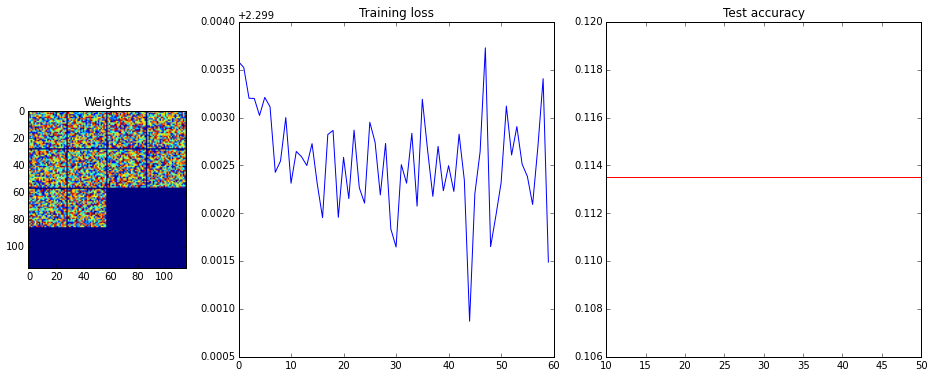

1312.23436785


In [15]:
from time import time
thetime = time()

indices = np.arange(n_samples)
for t in xrange(n_epochs * n_batches_per_epoch):
    i = t % n_batches_per_epoch
    
    # Shuffle dataset after each epoch.
    if i == 0:
        np.random.shuffle(indices)
        
    # Perform testing (using model.test)
    if t % test_iter == 0 and t != 0:
        # Your code goes here. ################################################ 
        test_accuracy['ts'].append(t)
        test_accuracy['values'].append(model.test(X[-10000:,:],y[-10000:]))
        # Your code goes here. ################################################ 
    
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_indices = indices[start : end]
    
    batch = (X[batch_indices, :], np.int32(y[batch_indices]))
    
    # Your code goes here. ####################################################
    model.set_input(batch[0], batch[1])
    model.fprop()
    model.bprop()
    training_loss['ts'].append(t)
    training_loss['values'].append(model.get_loss())
    # Your code goes here. ################################################ 
    
    # Visualize training process.
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 2]) 
    
    ax = plt.subplot(gs[0])
    ax.set_title("Weights")
    vis_square(model.layers[0].params['W']['data'].reshape((-1, 28, 28))[: 25, :, :])

    ax = plt.subplot(gs[1])
    ax.set_title("Training loss")
    plt.plot(training_loss['ts'], training_loss['values'], 'b')
    
    ax = plt.subplot(gs[2])
    ax.set_title("Test accuracy")
    plt.plot(test_accuracy['ts'], test_accuracy['values'], 'r')
    
    plt.show()
print time() - thetime

In [17]:
# Define a sequence of layers.
# Your code goes here. ######################################################## 
# desc = []
desc = [\
    InnerProductLayer(X.shape[1], 500, W=XavierFiller(), b=ConstantFiller(0.0)),\
    ReluLayer(),\
    InnerProductLayer(500, 10, W=XavierFiller(), b=ConstantFiller(0.0)),\    
    SoftmaxLossLayer()\
]

model = MLP(desc)
 
training_loss = {
    'ts': [],
    'values': []
}
test_accuracy = {
    'ts': [],
    'values': []
}

indices = np.arange(n_samples)
for t in xrange(n_epochs * n_batches_per_epoch):
    i = t % n_batches_per_epoch
    
    # Shuffle dataset after each epoch.
    if i == 0:
        np.random.shuffle(indices)
        
    # Perform testing (using model.test)
    if t % test_iter == 0 and t != 0:
        model.test()
        # Your code goes here. ################################################ 
    
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_indices = indices[start : end]
    
    batch = (X[batch_indices, :], np.int32(y[batch_indices]))
    
    
    # Your code goes here. ####################################################
    
    # Visualize training process.
    display.clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 2]) 
    
    ax = plt.subplot(gs[0])
    ax.set_title("Weights")
    vis_square(model.layers[0].params['W']['data'].reshape((-1, 28, 28))[: 25, :, :])

    ax = plt.subplot(gs[1])
    ax.set_title("Training loss")
    plt.plot(training_loss['ts'], training_loss['values'], 'b')
    
    ax = plt.subplot(gs[2])
    ax.set_title("Test accuracy")
    plt.plot(test_accuracy['ts'], test_accuracy['values'], 'r')
    
    plt.show()

SyntaxError: invalid syntax (<ipython-input-17-923a72fd3a1d>, line 52)

If you are experiencing problems with convergence, try applying a schedule, e.g. something like `inv`-policy from `Caffe`:
$$
    \mathtt{base\_lr} \cdot (1 + \gamma \cdot \mathtt{t})^{-p} \, .
$$
See `Caffe` [examples](https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet_solver.prototxt) for typical values of $ \gamma $ and $ p $.

## What has it learned?

Given a learned classification model and a class of interest one may numerically generate an image, which is representative of the class in terms of the ANN class scoring model.

More formally, let $ S_c(I) $ be the score of the class $ c $, computed by the classification layer of the network for an image $ I $. We would like to find an $ \mathcal{L}_2 $-regularized image, such that the score $ S_c $ is high:
$$
    \arg\max_{I} S_c(I) - \lambda \| I \|_2^2 \, ,
$$
where $ \lambda $ is the regularisation parameter.

For additional details see the paper by [Simonyan et al., 2010](http://www.robots.ox.ac.uk/~vedaldi/assets/pubs/simonyan14deep.pdf).

**Your task** is to get those reconstructed images for all 10 digits using previously trained multi-layer perceptron. This can be done by slightly modifying the optimization procedure implemented above. The following functions may come handy in that:

In [37]:
def dump_weights(filename, model):
    """ Dumps all tunable parameters of the model into a file. """
    with open(filename, 'wb') as f:
        for param in model.params:
            for v in param.values():
                np.save(f, v)
                
def load_weights(filename, model):
    """ 
    Loads all tunable parameters from file into the specified model. 
    
    NOTE: The model doesn't have to be of the same architecture as the model
          that was used to dump the parameters. The only requirement is
          the order of the tunable parameters.
    """
    with open(filename, 'rb') as f:
        for param in model.params:
            for v in param.values():
                v[:] = np.load(f)

Few tips:
* You may want to define an additional loss function corresponding to value of the neuron.
* As it pointed out in the original paper it better to optimize the output of the last linear layer rather than the output of Softmax.
* Try starting with a zero image.

Give few comments on obtained reconstructions.